In [1]:
import pandas as pd
import numpy as np

# Project introduction

For our machine learning project, we want to try and predict a Airbnb's avaliability for a given month using listing data.

# Data Preperation

## Data cleaning

In [2]:
# generate two data frames containing all of the listing and calendar data for each location
import os
import pandas as pd

directory_path = 'home_rentals/'

# Initialize an empty list to store DataFrames
listing_df = []
calendar_df = []

# Iterate through subdirectories
for subdirectory in os.listdir(directory_path):
    subdirectory_path = os.path.join(directory_path, subdirectory) 

    csv_listing_file_path = os.path.join(subdirectory_path, "listings.csv.gz")
    csv_calendar_file_path = os.path.join(subdirectory_path, "calendar.csv.gz")
    print(csv_listing_file_path)
    print(csv_calendar_file_path)

    df1 = pd.read_csv(csv_listing_file_path)
    df2 = pd.read_csv(csv_calendar_file_path)

    df1['location'] = subdirectory
    df2['location'] = subdirectory

    listing_df.append(df1)
    calendar_df.append(df2)


# Concatenate all DataFrames into a single DataFrame
all_listing_df = pd.concat(listing_df, ignore_index=True)
all_calendar_df = pd.concat(calendar_df, ignore_index=True)

home_rentals/Zurich/listings.csv.gz
home_rentals/Zurich/calendar.csv.gz


home_rentals/Barcelona/listings.csv.gz
home_rentals/Barcelona/calendar.csv.gz
home_rentals/Milan/listings.csv.gz
home_rentals/Milan/calendar.csv.gz
home_rentals/Valencia/listings.csv.gz
home_rentals/Valencia/calendar.csv.gz
home_rentals/Mallorca/listings.csv.gz
home_rentals/Mallorca/calendar.csv.gz
home_rentals/Washington/listings.csv.gz
home_rentals/Washington/calendar.csv.gz
home_rentals/Rotterdam/listings.csv.gz
home_rentals/Rotterdam/calendar.csv.gz
home_rentals/Tokyo/listings.csv.gz
home_rentals/Tokyo/calendar.csv.gz
home_rentals/Los Angeles/listings.csv.gz
home_rentals/Los Angeles/calendar.csv.gz
home_rentals/Lisbon/listings.csv.gz
home_rentals/Lisbon/calendar.csv.gz
home_rentals/Ireland/listings.csv.gz
home_rentals/Ireland/calendar.csv.gz
home_rentals/Mexico City/listings.csv.gz
home_rentals/Mexico City/calendar.csv.gz
home_rentals/Madrid/listings.csv.gz
home_rentals/Madrid/calendar.csv.gz
home_rentals/Geneva/listings.csv.gz
home_rentals/Geneva/calendar.csv.gz
home_rentals/Euska

In [3]:
all_calendar_df

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights,location
0,73282,2022-09-23,f,$100.00,$100.00,1125.0,1125.0,Zurich
1,73282,2022-09-24,f,$100.00,$100.00,1125.0,1125.0,Zurich
2,73282,2022-09-25,f,$100.00,$100.00,1125.0,1125.0,Zurich
3,73282,2022-09-26,f,$100.00,$100.00,1125.0,1125.0,Zurich
4,73282,2022-09-27,f,$100.00,$100.00,1125.0,1125.0,Zurich
...,...,...,...,...,...,...,...,...
124889345,1825432,2023-09-24,t,$150.00,$140.00,2.0,1125.0,Malaga
124889346,1825432,2023-09-25,t,$150.00,$140.00,2.0,1125.0,Malaga
124889347,1825432,2023-09-26,t,$150.00,$140.00,2.0,1125.0,Malaga
124889348,1825432,2023-09-27,t,$150.00,$140.00,2.0,1125.0,Malaga


In [4]:
all_listing_df.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

### Removing Irrelevant columns 

Since this dataset has a lot of variables, we can start by removing colums that will be clearly irrelevant for our research question such as the following:

- *'scrape_id', 'last_scraped', 'source', 'picture_url', 'host_id', 'host_thumbnail_url', host_url', 'host_name'*  = Identifier variables
-  *'name', 'description', 'neighborhood_overview', 'host_about', 'bathrooms_text'*  = We will not be working with textual data for this analysis, for the sake of efficiency and time
- *'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude','longitude', region_name', 'region_parent_id', 'region_parent_name','region_parent_parent_id', 'region_parent_parent_name'* = We will only be using Country in our analysis as a geographic identifier, in order to reduce the dimension of our data while keeping some identifiabiltiy (since there are 20 countries)
- *'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availability_365'* = These are variables that will be dependant on our predictor variable in this analysis 

In [5]:
columns_drop = ['scrape_id', 'last_scraped', 'source', 'picture_url', 'host_id', 'host_thumbnail_url', 'host_url','name', 
                    'description', 'neighborhood_overview', 'host_about', 'bathrooms_text', 'neighbourhood',
                      'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude','longitude',
                    'region_name', 'region_parent_id', 'region_parent_name','region_parent_parent_id', 'region_parent_parent_name',
                      'has_availability', 'availability_60', 'availability_90', 
                      
                      'host_id','host_url', 'host_name', 'host_since', 'host_location', 'host_about',
                      'host_response_time', 'host_response_rate', 'host_acceptance_rate',
                      'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
                      'host_neighbourhood', 'host_listings_count',
                      'host_total_listings_count', 'host_verifications',
                      'host_has_profile_pic', 'host_identity_verified', 'calculated_host_listings_count',
                      'calculated_host_listings_count_entire_homes',
                      'calculated_host_listings_count_private_rooms',
                      'calculated_host_listings_count_shared_rooms', 'reviews_per_month', 'listing_url',
                       'minimum_minimum_nights', 'maximum_minimum_nights',
                      'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 
                      'calendar_last_scraped', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review',
                      'last_review', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
                      'review_scores_communication', 'review_scores_location', 'review_scores_value', 'license', 'requires_license', 
                      'instant_bookable', 'last_searched', 'region_id', 'listings.csv', 'beds', 'bedrooms']

all_listing_df_1 = all_listing_df.drop(columns=columns_drop) 

### Creating columns for amenities

In [63]:
# clean out all of the rows that have NaN in the amenities column


# Check for NaN values in the "amenities" column
nan_rows = all_listing_df_1[all_listing_df_1['amenities'].isna()]

# Remove rows with NaN values in the "amenities" column
all_listing_df_1_cleaned = all_listing_df_1.dropna(subset=['amenities'])


In [70]:
'''
import numpy as np 

# Check for NaN values in the "amenities" column
nan_rows = all_listing_df_1[all_listing_df_1['amenities'].isna()]

# Remove rows with NaN values in the "amenities" column
all_listing_df_1_cleaned = all_listing_df_1.dropna(subset=['amenities'])

# since "amenities" contains a list with all of the amenities, we have to first extract these
# Create a new DataFrame by repeating rows based on the number of elements in each "amenities" list
df_repeated = pd.DataFrame({
    'id': all_listing_df_1_cleaned['id'].repeat(all_listing_df_1_cleaned['amenities'].apply(len)),
    'amenities': [item for sublist in all_listing_df_1_cleaned['amenities'] for item in sublist]
})

# Join the strings in the 'amenities' column by using ', '.join
df_repeated['amenities'] = df_repeated['amenities'].apply(', '.join)


# make an array of zeroes in which to put the frequency each amenity appears in the listings
#amenities_count = np.zeros_like(unique_amenities)

#for amenity in unique_amenities:
all_listing_df_1_cleaned
'''


'\nimport numpy as np \n\n# Check for NaN values in the "amenities" column\nnan_rows = all_listing_df_1[all_listing_df_1[\'amenities\'].isna()]\n\n# Remove rows with NaN values in the "amenities" column\nall_listing_df_1_cleaned = all_listing_df_1.dropna(subset=[\'amenities\'])\n\n# since "amenities" contains a list with all of the amenities, we have to first extract these\n# Create a new DataFrame by repeating rows based on the number of elements in each "amenities" list\ndf_repeated = pd.DataFrame({\n    \'id\': all_listing_df_1_cleaned[\'id\'].repeat(all_listing_df_1_cleaned[\'amenities\'].apply(len)),\n    \'amenities\': [item for sublist in all_listing_df_1_cleaned[\'amenities\'] for item in sublist]\n})\n\n# Join the strings in the \'amenities\' column by using \', \'.join\ndf_repeated[\'amenities\'] = df_repeated[\'amenities\'].apply(\', \'.join)\n\n\n# make an array of zeroes in which to put the frequency each amenity appears in the listings\n#amenities_count = np.zeros_like(un

In [7]:
""""
# Extract amenities from the JSON array and create dummy columns
df_amenities = all_listing_df_1['amenities'].str.strip('[]').str.replace('"', '').str.get_dummies(', ')

# Add a prefix to the dummy columns
df_amenities = df_amenities.add_prefix('amenity_')

# Concatenate the dummy columns with the original DataFrame
df = pd.concat([all_listing_df_1, df_amenities], axis=1)

# Drop the original 'amenities' column if you want
df = df.drop('amenities', axis=1)

# Display the resulting DataFrame

""" 


'"\n# Extract amenities from the JSON array and create dummy columns\ndf_amenities = all_listing_df_1[\'amenities\'].str.strip(\'[]\').str.replace(\'"\', \'\').str.get_dummies(\', \')\n\n# Add a prefix to the dummy columns\ndf_amenities = df_amenities.add_prefix(\'amenity_\')\n\n# Concatenate the dummy columns with the original DataFrame\ndf = pd.concat([all_listing_df_1, df_amenities], axis=1)\n\n# Drop the original \'amenities\' column if you want\ndf = df.drop(\'amenities\', axis=1)\n\n# Display the resulting DataFrame\n\n'

In [71]:

all_listing_df_1['amenities'].unique()





array(['["Essentials", "Kitchen", "Hot tub", "Lake access", "Wifi", "Long term stays allowed", "Dryer", "Heating", "Cable TV", "Elevator", "Washer", "TV with standard cable"]',
       '["Essentials", "Indoor fireplace", "Kitchen", "Smart lock", "Smoke alarm", "Wifi", "Long term stays allowed", "Hair dryer", "Shampoo", "Cable TV", "Heating", "Elevator", "Air conditioning", "Fire extinguisher", "TV with standard cable"]',
       '["Essentials", "Stove", "Wifi", "Long term stays allowed", "Microwave", "Hair dryer", "Cable TV", "Elevator", "Dryer", "Coffee maker", "Baking sheet", "Smoke alarm", "Paid parking on premises", "Hangers", "Washer", "Refrigerator", "Bed linens", "Kitchen", "Dishwasher", "Cooking basics", "Paid parking off premises", "Heating", "Shampoo", "Oven", "Shower gel", "Hot water", "Private patio or balcony", "Dishes and silverware", "Iron", "TV with standard cable"]',
       ...,
       '["Heating", "Hair dryer", "Coffee maker", "42\\" HDTV", "Private patio or balcony", "

In [72]:
import ast


# Assuming your DataFrame is named 'df' and the column is named 'amenities'
# If the amenities column is not already a list, convert it using ast.literal_eval
all_listing_df_1['amenities'] = all_listing_df_1['amenities'].apply(ast.literal_eval)

# Initialize an empty set to store unique amenities
unique_amenities = set()

# Iterate through each row in the DataFrame
for index, row in all_listing_df_1.iterrows():
    # Get the amenities for the current row
    amenities_list = row['amenities']

    # Update the set with the unique amenities for this row
    unique_amenities.update(amenities_list)

# Convert the set back to a list
unique_amenities_list = list(unique_amenities)

# Print the unique amenities list
print(unique_amenities_list)

ValueError: malformed node or string: nan

### Remove rows and columns that have significant amount of NAN values 
 

In [9]:
import pandas as pd
import json

# Use json_normalize to flatten the JSON column
normalized_df = pd.json_normalize(all_listing_df_1_cleaned['amenities'])

# Concatenate the new DataFrame with the original DataFrame
result_df = pd.concat([all_listing_df_1_cleaned, normalized_df], axis=1)

# Drop the original 'amenities' column if needed
#result_df = result_df.drop('amenities', axis=1)




result_df

,id,property_type,room_type,accommodates,bathrooms,amenities,price,minimum_nights,maximum_nights,calendar_updated,...,111,112,113,114,115,116,117,118,119,120
0,73282.0,Entire rental unit,Entire home/apt,4.0,NaN,"[Fire extinguisher, Private entrance, Laundrom...",$49.00,3.0,28.0,NaN,...,None,None,None,None,None,None,None,None,None,None
1,86645.0,Entire rental unit,Entire home/apt,3.0,NaN,"[Wifi, Refrigerator, TV, Fire extinguisher, He...",$106.00,1.0,9999.0,NaN,...,None,None,None,None,None,None,None,None,None,None
2,143821.0,Entire loft,Entire home/apt,2.0,NaN,"[Safe, Fire extinguisher, Hp neutral, eco frie...",$136.00,2.0,356.0,NaN,...,None,None,None,None,None,None,None,None,None,None
3,178448.0,Private room in rental unit,Private room,1.0,NaN,"[Wifi, Shampoo, Refrigerator, Iron, Fire extin...",$75.00,2.0,1825.0,NaN,...,None,None,None,None,None,None,None,None,None,None
4,204586.0,Private room in rental unit,Private room,1.0,NaN,"[Wifi, Shampoo, Refrigerator, Iron, Fire extin...",$55.00,2.0,730.0,NaN,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342232,5.721959e+17,Entire serviced apartment,Entire home/apt,6.0,NaN,"[65"" HDTV with standard cable, Essentials, Sto...",$350.00,3.0,90.0,NaN,...,None,None,None,None,None,None,None,None,None,None
342233,4.607863e+07,Room in hotel,Private room,6.0,NaN,"[Essentials, Wifi, Long term stays allowed, Bu...",$285.00,1.0,1125.0,NaN,...,None,None,None,None,None,None,None,None,None,None
342234,4.647998e+07,Room in hotel,Private room,2.0,NaN,"[Children’s books and toys, Essentials, Wifi, ...",$105.00,9.0,1125.0,NaN,...,None,None,None,None,None,None,None,None,None,None
342235,4.672216e+07,Room in hotel,Private room,2.0,NaN,"[Essentials, Wifi, Long term stays allowed, Bu...",$155.00,10.0,1125.0,NaN,...,None,None,None,None,None,None,None,None,None,None


In [7]:
""""
# Extract amenities from the JSON array and create dummy columns
df_amenities = all_listing_df_1['amenities'].str.strip('[]').str.replace('"', '').str.get_dummies(', ')

# Add a prefix to the dummy columns
df_amenities = df_amenities.add_prefix('amenity_')

# Concatenate the dummy columns with the original DataFrame
df = pd.concat([all_listing_df_1, df_amenities], axis=1)

# Drop the original 'amenities' column if you want
df = df.drop('amenities', axis=1)

# Display the resulting DataFrame

""" 


'"\n# Extract amenities from the JSON array and create dummy columns\ndf_amenities = all_listing_df_1[\'amenities\'].str.strip(\'[]\').str.replace(\'"\', \'\').str.get_dummies(\', \')\n\n# Add a prefix to the dummy columns\ndf_amenities = df_amenities.add_prefix(\'amenity_\')\n\n# Concatenate the dummy columns with the original DataFrame\ndf = pd.concat([all_listing_df_1, df_amenities], axis=1)\n\n# Drop the original \'amenities\' column if you want\ndf = df.drop(\'amenities\', axis=1)\n\n# Display the resulting DataFrame\n\n'

### Remove rows and columns that have significant amount of NAN values 
 

In [9]:
all_listing_df_1 


,id,property_type,room_type,accommodates,bathrooms,amenities,price,minimum_nights,maximum_nights,calendar_updated,availability_30,availability_365,location
0,2.818000e+03,Private room in rental unit,Private room,2.0,NaN,"[""Fire extinguisher"", ""Private entrance"", ""Lau...",$49.00,3.0,28.0,NaN,1.0,14.0,Amsterdam
1,2.016800e+04,Private room in townhouse,Private room,2.0,NaN,"[""Wifi"", ""Refrigerator"", ""TV"", ""Fire extinguis...",$106.00,1.0,365.0,NaN,0.0,0.0,Amsterdam
2,2.788600e+04,Private room in houseboat,Private room,2.0,NaN,"[""Safe"", ""Fire extinguisher"", ""Hp neutral, eco...",$136.00,2.0,356.0,NaN,0.0,121.0,Amsterdam
3,2.887100e+04,Private room in rental unit,Private room,2.0,NaN,"[""Wifi"", ""Shampoo"", ""Refrigerator"", ""Iron"", ""F...",$75.00,2.0,1825.0,NaN,4.0,117.0,Amsterdam
4,2.905100e+04,Private room in rental unit,Private room,1.0,NaN,"[""Wifi"", ""Shampoo"", ""Refrigerator"", ""Iron"", ""F...",$55.00,2.0,730.0,NaN,0.0,160.0,Amsterdam
...,...,...,...,...,...,...,...,...,...,...,...,...,...
342232,32705544.0,Entire rental unit,Entire home/apt,2.0,NaN,"[""Heating"", ""Hair dryer"", ""Crib"", ""Extra pillo...",$31.00,5.0,1125.0,NaN,3.0,3.0,Malaga
342233,33294303.0,Entire rental unit,Entire home/apt,4.0,NaN,"[""Heating"", ""Hair dryer"", ""Coffee maker"", ""42\...",$90.00,3.0,1125.0,NaN,0.0,2.0,Malaga
342234,50607554.0,Tiny home,Entire home/apt,4.0,NaN,"[""Heating"", ""Hair dryer"", ""Coffee maker"", ""Pri...",$112.00,3.0,1125.0,NaN,0.0,0.0,Malaga
342235,33469519.0,Entire condo,Entire home/apt,6.0,NaN,"[""Heating"", ""Hair dryer"", ""Crib"", ""Paid parkin...",$125.00,2.0,1125.0,NaN,0.0,1.0,Malaga


In [10]:
#remove all columnns with more than 50% of NaN values 
all_listing_df_2 = all_listing_df_1.dropna(thresh=0.5*len(all_listing_df_1), axis=1)
all_listing_df_2

,id,property_type,room_type,accommodates,amenities,price,minimum_nights,maximum_nights,availability_30,availability_365,location
0,73282.0,Entire rental unit,Entire home/apt,4.0,"[""Essentials"", ""Kitchen"", ""Hot tub"", ""Lake acc...",$100.00,1125.0,1125.0,23.0,358.0,Zurich
1,86645.0,Entire rental unit,Entire home/apt,3.0,"[""Essentials"", ""Indoor fireplace"", ""Kitchen"", ...",$184.00,1.0,9999.0,0.0,0.0,Zurich
2,143821.0,Entire loft,Entire home/apt,2.0,"[""Essentials"", ""Stove"", ""Wifi"", ""Long term sta...",$200.00,3.0,365.0,0.0,145.0,Zurich
3,178448.0,Private room in rental unit,Private room,1.0,"[""Kitchen"", ""Lake access"", ""Wifi"", ""Long term ...",$60.00,5.0,31.0,0.0,221.0,Zurich
4,204586.0,Private room in rental unit,Private room,1.0,"[""Kitchen"", ""Indoor fireplace"", ""Free parking ...",$200.00,3.0,6.0,29.0,364.0,Zurich
...,...,...,...,...,...,...,...,...,...,...,...
342231,50352276.0,Entire rental unit,Entire home/apt,6.0,"[""Heating"", ""Private patio or balcony"", ""Dishe...",$265.00,21.0,60.0,0.0,0.0,Malaga
342232,32705544.0,Entire rental unit,Entire home/apt,2.0,"[""Heating"", ""Hair dryer"", ""Crib"", ""Extra pillo...",$31.00,5.0,1125.0,3.0,3.0,Malaga
342233,33294303.0,Entire rental unit,Entire home/apt,4.0,"[""Heating"", ""Hair dryer"", ""Coffee maker"", ""42\...",$90.00,3.0,1125.0,0.0,2.0,Malaga
342234,50607554.0,Tiny home,Entire home/apt,4.0,"[""Heating"", ""Hair dryer"", ""Coffee maker"", ""Pri...",$112.00,3.0,1125.0,0.0,0.0,Malaga


In [11]:
removed_columns=[col for col in all_listing_df_1 if col not in all_listing_df_2]

print(f'the columns removed are {removed_columns}')

the columns removed are ['bathrooms', 'calendar_updated']


In [12]:
#After removing all the columns with more than 50% of NaN values we are now going to look at rows and remove those too
threshold = 0.70 
all_listing_df_3 = all_listing_df_2.dropna(thresh=float(threshold * len(all_listing_df_2.columns)))
removed_rows = len(all_listing_df_2) - len(all_listing_df_3)
print(f'num of removed rows is {removed_rows}')

all_listing_df_3

num of removed rows is 1


,id,property_type,room_type,accommodates,amenities,price,minimum_nights,maximum_nights,availability_30,availability_365,location
0,73282.0,Entire rental unit,Entire home/apt,4.0,"[""Essentials"", ""Kitchen"", ""Hot tub"", ""Lake acc...",$100.00,1125.0,1125.0,23.0,358.0,Zurich
1,86645.0,Entire rental unit,Entire home/apt,3.0,"[""Essentials"", ""Indoor fireplace"", ""Kitchen"", ...",$184.00,1.0,9999.0,0.0,0.0,Zurich
2,143821.0,Entire loft,Entire home/apt,2.0,"[""Essentials"", ""Stove"", ""Wifi"", ""Long term sta...",$200.00,3.0,365.0,0.0,145.0,Zurich
3,178448.0,Private room in rental unit,Private room,1.0,"[""Kitchen"", ""Lake access"", ""Wifi"", ""Long term ...",$60.00,5.0,31.0,0.0,221.0,Zurich
4,204586.0,Private room in rental unit,Private room,1.0,"[""Kitchen"", ""Indoor fireplace"", ""Free parking ...",$200.00,3.0,6.0,29.0,364.0,Zurich
...,...,...,...,...,...,...,...,...,...,...,...
342231,50352276.0,Entire rental unit,Entire home/apt,6.0,"[""Heating"", ""Private patio or balcony"", ""Dishe...",$265.00,21.0,60.0,0.0,0.0,Malaga
342232,32705544.0,Entire rental unit,Entire home/apt,2.0,"[""Heating"", ""Hair dryer"", ""Crib"", ""Extra pillo...",$31.00,5.0,1125.0,3.0,3.0,Malaga
342233,33294303.0,Entire rental unit,Entire home/apt,4.0,"[""Heating"", ""Hair dryer"", ""Coffee maker"", ""42\...",$90.00,3.0,1125.0,0.0,2.0,Malaga
342234,50607554.0,Tiny home,Entire home/apt,4.0,"[""Heating"", ""Hair dryer"", ""Coffee maker"", ""Pri...",$112.00,3.0,1125.0,0.0,0.0,Malaga


In [13]:
all_listing_df_3["room_type"].value_counts()

Entire home/apt    244135
Private room        91261
Shared room          3788
Hotel room           3051
Name: room_type, dtype: int64

In [14]:
# remove hotel rooms since they are irrelevant to our investors 
all_listing_df_4 = all_listing_df_3[all_listing_df_3['room_type'] != 'Hotel room']
all_listing_df_4["room_type"].value_counts()


room_type
Entire home/apt    244135
Private room        91261
Shared room          3788
Name: count, dtype: int64

In [15]:
all_listing_df_4["property_type"].value_counts()


property_type
Entire rental unit             121893
Entire home                     36243
Private room in rental unit     34444
Entire condo                    33638
Private room in home            21393
                                ...  
Shared room in tower                1
Shared room in train                1
Private room in ice dome            1
Private room in ranch               1
Shared room in ice dome             1
Name: count, Length: 150, dtype: int64

In [16]:
check_hotel_listed_as_private_room_df = all_listing_df_4[all_listing_df_4["property_type"] == "Room in hotel"]

check_hotel_listed_as_private_room_df["room_type"].value_counts()

room_type
Private room       3126
Entire home/apt       3
Name: count, dtype: int64

In [17]:
# remove hotels hiding within propety type 
filtered_df = all_listing_df_4[~all_listing_df_4['property_type'].str.contains(
    'hotel', case=False, na=False)]

In [18]:
# Calculate the proportion of each property type
property_type_counts = filtered_df['property_type'].value_counts(
    normalize=True)

# Set the threshold for the proportion  (0.005)
threshold = 0.005

# Get property types that meet the threshold
selected_property_types = property_type_counts[property_type_counts >= threshold].index

# Create all_listing_df_3 by filtering based on selected property types
all_listing_df_5 = filtered_df[filtered_df['property_type'].isin(
    selected_property_types)]

After removing hotels we found that there are "Rooms in Hotel" etc so we had to remove those as well

In [19]:
all_listing_df_5["property_type"].value_counts()

property_type
Entire rental unit                   121893
Entire home                           36243
Private room in rental unit           34444
Entire condo                          33638
Private room in home                  21393
Entire villa                           9502
Entire loft                            7446
Private room in condo                  7356
Private room in bed and breakfast      6463
Entire serviced apartment              6026
Entire guest suite                     5967
Entire townhouse                       5039
Entire guesthouse                      4210
Entire cottage                         4184
Private room in townhouse              2711
Entire vacation home                   2194
Entire bungalow                        2012
Private room in guest suite            1810
Name: count, dtype: int64

In [20]:
# filtered_property_types = filtered_df['property_type'].unique()

# # Filter out rows in all_listing_df_4 where 'property_type' matches any in filtered_property_types
# all_listing_df_5 = all_listing_df_4[~all_listing_df_4['property_type'].isin(
#     filtered_property_types)]

# Display the resulting DataFrame
removed_rows = len(all_listing_df_4) - len(all_listing_df_5)
removed_property_types = len(
    all_listing_df_4['property_type'].unique()) - len(all_listing_df_5['property_type'].unique())

print(f'num of removed rows is {removed_rows}')
print(f'number of property types removed {removed_property_types}')

all_listing_df_5

num of removed rows is 26653
number of property types removed 132


id                property_type        room_type  \
0       2.818000e+03  Private room in rental unit     Private room   
1       2.016800e+04    Private room in townhouse     Private room   
3       2.887100e+04  Private room in rental unit     Private room   
4       2.905100e+04  Private room in rental unit     Private room   
5       4.439100e+04           Entire rental unit  Entire home/apt   
...              ...                          ...              ...   
342225  6.555674e+17  Private room in rental unit     Private room   
342226  3.820260e+07           Entire rental unit  Entire home/apt   
342227  4.205430e+07  Private room in rental unit     Private room   
342231  5.295024e+07           Entire rental unit  Entire home/apt   
342232  5.721959e+17    Entire serviced apartment  Entire home/apt   

        accommodates                                          amenities  \
0                2.0  ["Fire extinguisher", "Private entrance", "Lau...   
1                2.0  ["Wifi", "Refrigerator", "TV", "Fire extinguis...   
3                2.0  ["Wifi", "Shampoo", "Refrigerator", "Iron", "F...   
4                1.0  ["Wifi", "Shampoo", "Refrigerator", "Iron", "F...   
5                4.0  ["Microwave", "Private entrance", "Oven", "Pat...   
...              ...                                                ...   
342225           2.0  ["Essentials", "Kitchen", "Cooking basics", "W...   
342226           3.0  ["Children\u2019s books and toys", "Essentials...   
342227           1.0  ["Bed linens", "Essentials", "Kitchen", "Smoke...   
342231           4.0  ["Essentials", "Cleaning products", "Wifi", "L...   
342232           6.0  ["65\" HDTV with standard cable", "Essentials"...   

        accommodates                                          amenities  \
0                4.0  ["Essentials", "Kitchen", "Hot tub", "Lake acc...   
1                3.0  ["Essentials", "Indoor fireplace", "Kitchen", ...   
2                2.0  ["Essentials", "Stove", "Wifi", "Long term sta...   
3                1.0  ["Kitchen", "Lake access", "Wifi", "Long term ...   
4                1.0  ["Kitchen", "Indoor fireplace", "Free parking ...   
...              ...                                                ...   
342230           4.0  ["Heating", "Hair dryer", "Crib", "Extra pillo...   
342231           6.0  ["Heating", "Private patio or balcony", "Dishe...   
342232           2.0  ["Heating", "Hair dryer", "Crib", "Extra pillo...   
342233           4.0  ["Heating", "Hair dryer", "Coffee maker", "42\...   
342235           6.0  ["Heating", "Hair dryer", "Crib", "Paid parkin...   

          price  minimum_nights  maximum_nights  availability_30  \
0       $100.00          1125.0          1125.0             23.0   
1       $184.00             1.0          9999.0              0.0   
2       $200.00             3.0           365.0              0.0   
3        $60.00             5.0            31.0              0.0   
4       $200.00             3.0             6.0             29.0   
...         ...             ...             ...              ...   
342230   $72.00             5.0            90.0              4.0   
342231  $265.00            21.0            60.0              0.0   
342232   $31.00             5.0          1125.0              3.0   
342233   $90.00             3.0          1125.0              0.0   
342235  $125.00             2.0          1125.0              0.0   

        availability_365 location  
0                  358.0   Zurich  
1                    0.0   Zurich  
2                  145.0   Zurich  
3                  221.0   Zurich  
4                  364.0   Zurich  
...                  ...      ...  
342230               5.0   Malaga  
342231               0.0   Malaga  
342232               3.0   Malaga  
342233               2.0   Malaga  
342235               1.0   Malaga  

[312531 rows x 11 columns]

c:\Program Files\Python310\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


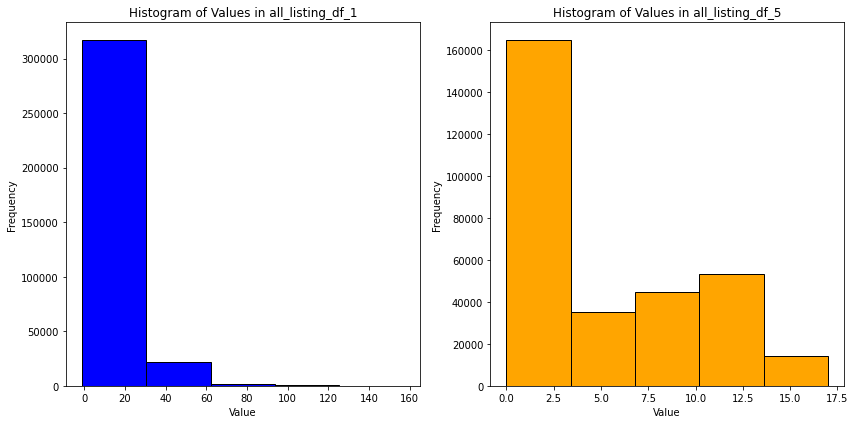

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

temp_df_1 = all_listing_df_1.copy()
temp_df_5 = all_listing_df_5.copy()

# Factorize 'property_type' for temporary DataFrames
temp_df_1['property_type'] = pd.factorize(temp_df_1['property_type'])[0]
temp_df_5['property_type'] = pd.factorize(temp_df_5['property_type'])[0]

plt.figure(figsize=(12, 6))

# Plot the histogram of 'property_type' in all_listing_df_1
plt.subplot(1, 2, 1)
temp_df_1['property_type'].plot(kind='hist', bins=5, edgecolor='black', color='blue')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Values in all_listing_df_1')

# Plot the histogram of 'property_type' in all_listing_df_5
plt.subplot(1, 2, 2)
temp_df_5['property_type'].plot(kind='hist', bins=5, edgecolor='black', color='orange')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Values in all_listing_df_5')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


In [22]:
all_listing_df_5["room_type"].value_counts()

room_type
Entire home/apt    238354
Private room        74177
Name: count, dtype: int64

Now, we are going to check that there are no erros in availability (e.g. that no property is available for more than 30 days per month)

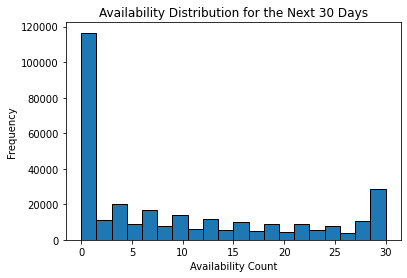

In [23]:
import matplotlib.pyplot as plt

plt.hist(all_listing_df_5["availability_30"], bins=20, edgecolor='black')  
plt.title("Availability Distribution for the Next 30 Days")
plt.xlabel("Availability Count")
plt.ylabel("Frequency")
plt.show()


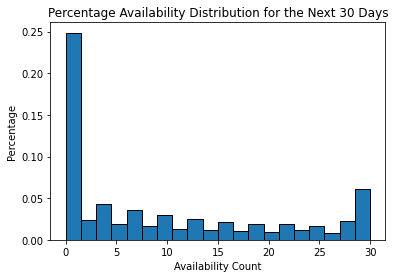

In [24]:
import matplotlib.pyplot as plt

# Assuming all_listing_df_5 is your DataFrame
plt.hist(all_listing_df_5["availability_30"], bins=20, density=True, edgecolor='black')  # density=True for percentage histogram
plt.title("Percentage Availability Distribution for the Next 30 Days")
plt.xlabel("Availability Count")
plt.ylabel("Percentage")
plt.show()


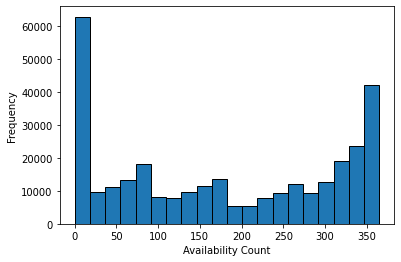

In [25]:
import matplotlib.pyplot as plt
plt.hist(all_listing_df_5["availability_365"], bins=20, edgecolor='black')  
plt.xlabel("Availability Count")
plt.ylabel("Frequency")
plt.show()


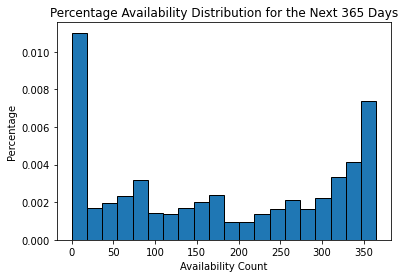

In [26]:
import matplotlib.pyplot as plt

# Assuming all_listing_df_5 is your DataFrame
plt.hist(all_listing_df_5["availability_365"], bins=20, density=True, edgecolor='black')  # density=True for percentage histogram
plt.title("Percentage Availability Distribution for the Next 365 Days")
plt.xlabel("Availability Count")
plt.ylabel("Percentage")
plt.show()


Since we focus on properties that are going to be rented out for short term stays (targeting tourists) we will now look at the minimum_nights column, and remove all properties that have a high requested minimum_nights (since these would be long term stays)

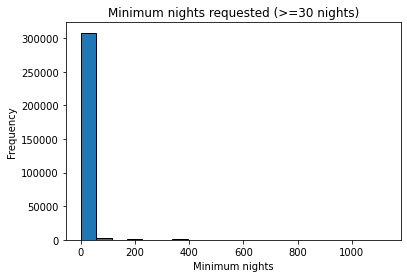

In [27]:
import matplotlib.pyplot as plt

plt.hist(all_listing_df_5["minimum_nights"], bins=20, edgecolor='black')  # Adjust the number of bins as needed
plt.title("Minimum nights requested (>=30 nights)")
plt.xlabel("Minimum nights")
plt.ylabel("Frequency")
plt.show()

##we can see that there are minimum nights close to 400 nights


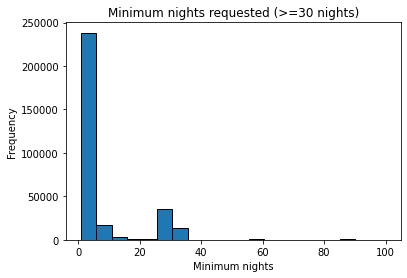

In [28]:
import matplotlib.pyplot as plt
filtered_df = all_listing_df_5[all_listing_df_5["minimum_nights"] <= 100]

plt.hist(filtered_df["minimum_nights"], bins=20, edgecolor='black') 
plt.title("Minimum nights requested (>=30 nights)")
plt.xlabel("Minimum nights")
plt.ylabel("Frequency")
plt.show()


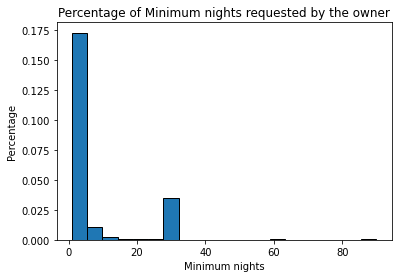

In [29]:
# Assuming all_listing_df_5 is your DataFrame
filtered_df = all_listing_df_5[all_listing_df_5["minimum_nights"] <= 90]
plt.hist(filtered_df["minimum_nights"], bins=20, density=True, edgecolor='black')  # density=True for percentage histogram
plt.title("Percentage of Minimum nights requested by the owner")
plt.xlabel("Minimum nights")
plt.ylabel("Percentage")
plt.show()

In [30]:
# Assuming all_listing_df_5 is your DataFrame

all_listing_df_5["minimum_nights"] = all_listing_df_5["minimum_nights"].astype(int)

counts = all_listing_df_5["minimum_nights"].value_counts(bins=range(0, max(all_listing_df_5["minimum_nights"]) + 31, 30))

# Calculate the percentage column
percentage_column = (counts / len(all_listing_df_5)) * 100

# Create a new DataFrame with counts and percentage_column
result_df = pd.DataFrame({'Counts': counts, 'Percentage': percentage_column})

# Print or display the result DataFrame
print(result_df)


                  Counts  Percentage
(-0.001, 30.0]    294842   94.340081
(30.0, 60.0]       14309    4.578426
(60.0, 90.0]        1315    0.420758
(90.0, 120.0]        509    0.162864
(150.0, 180.0]       487    0.155825
(360.0, 390.0]       463    0.148145
(180.0, 210.0]       124    0.039676
(120.0, 150.0]       113    0.036156
(270.0, 300.0]       102    0.032637
(330.0, 360.0]        70    0.022398
(990.0, 1020.0]       56    0.017918
(480.0, 510.0]        32    0.010239
(1110.0, 1140.0]      25    0.007999
(210.0, 240.0]        22    0.007039
(240.0, 270.0]        21    0.006719
(570.0, 600.0]         7    0.002240
(720.0, 750.0]         6    0.001920
(690.0, 720.0]         6    0.001920
(390.0, 420.0]         6    0.001920
(300.0, 330.0]         6    0.001920
(780.0, 810.0]         4    0.001280
(420.0, 450.0]         2    0.000640
(930.0, 960.0]         1    0.000320
(1080.0, 1110.0]       1    0.000320
(450.0, 480.0]         1    0.000320
(870.0, 900.0]         1    0.000320
(

We can see that more than 98% of all properties have requested a minimum stay of below 60. Therefore it makes sense to remove anything with minimum_nights requested above 60.  

In [31]:
# Assuming all_listing_df_5 is your DataFrame
all_listing_df_6 = all_listing_df_5[all_listing_df_5["minimum_nights"] <= 60]

#Display the filtered DataFrame
all_listing_df_6


,id,property_type,room_type,accommodates,amenities,price,minimum_nights,maximum_nights,availability_30,availability_365,location
0,2.818000e+03,Private room in rental unit,Private room,2.0,"[""Fire extinguisher"", ""Private entrance"", ""Lau...",$49.00,3,28.0,1.0,14.0,Amsterdam
1,2.016800e+04,Private room in townhouse,Private room,2.0,"[""Wifi"", ""Refrigerator"", ""TV"", ""Fire extinguis...",$106.00,1,365.0,0.0,0.0,Amsterdam
3,2.887100e+04,Private room in rental unit,Private room,2.0,"[""Wifi"", ""Shampoo"", ""Refrigerator"", ""Iron"", ""F...",$75.00,2,1825.0,4.0,117.0,Amsterdam
4,2.905100e+04,Private room in rental unit,Private room,1.0,"[""Wifi"", ""Shampoo"", ""Refrigerator"", ""Iron"", ""F...",$55.00,2,730.0,0.0,160.0,Amsterdam
5,4.439100e+04,Entire rental unit,Entire home/apt,4.0,"[""Microwave"", ""Private entrance"", ""Oven"", ""Pat...",$240.00,3,730.0,0.0,0.0,Amsterdam
...,...,...,...,...,...,...,...,...,...,...,...
342225,6.555674e+17,Private room in rental unit,Private room,2.0,"[""Essentials"", ""Kitchen"", ""Cooking basics"", ""W...",$85.00,1,365.0,0.0,0.0,Zurich
342226,3.820260e+07,Entire rental unit,Entire home/apt,3.0,"[""Children\u2019s books and toys"", ""Essentials...",$79.00,2,1125.0,0.0,0.0,Zurich
342227,4.205430e+07,Private room in rental unit,Private room,1.0,"[""Bed linens"", ""Essentials"", ""Kitchen"", ""Smoke...",$34.00,27,1125.0,0.0,0.0,Zurich
342231,5.295024e+07,Entire rental unit,Entire home/apt,4.0,"[""Essentials"", ""Cleaning products"", ""Wifi"", ""L...",$156.00,6,1125.0,1.0,1.0,Zurich


## Pricing Analysis

GABRIEL'S CODE IS PASTED BELOW:

In [32]:
#PLEASE CHECK IF THIS WORKS AND MAKES SENSE (i don't have enough ram in my laptop to concatenate the original dataframes ☠)

# WHEN RUNNING THIS, HAVE TO FIRST ADD BACK BEDS AND BEDROOMS TO THE DATA FRAME (AKA REMOVE THEM FROM THE "DROP" THING)
'''

# Plot distribution of prices
plt.figure(figsize=(12, 6))
sns.histplot(all_listing_df_6['price'], bins=30, kde=True)
plt.title('Distribution of Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

# Plot distribution of prices by country
plt.figure(figsize=(14, 6))
sns.boxplot(x='region_name', y='price', data=all_listing_df_6)
plt.title('Distribution of Prices by Country')
plt.xlabel('Country')
plt.ylabel('Price')
plt.xticks(rotation=45, ha='right')
plt.show()

# Calculate price per bedroom and price per bed
all_listing_df_6['price_per_bedroom'] = all_listing_df_6['price'] / all_listing_df_6['bedrooms']
all_listing_df_6['price_per_bed'] = all_listing_df_6['price'] / all_listing_df_6['beds']

# Plot distribution of price per bedroom and price per bed
plt.figure(figsize=(12, 6))
sns.histplot(all_listing_df_6['price_per_bedroom'], bins=30, kde=True, label='Price per Bedroom')
sns.histplot(all_listing_df_6['price_per_bed'], bins=30, kde=True, label='Price per Bed')
plt.title('Distribution of Price per Bedroom and Price per Bed')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Plot distribution of price per bedroom and price per bed by country
plt.figure(figsize=(14, 6))
sns.boxplot(x='region_name', y='price_per_bedroom', data=all_listing_df_6, label='Price per Bedroom')
sns.boxplot(x='region_name', y='price_per_bed', data=all_listing_df_6, label='Price per Bed')
plt.title('Distribution of Price per Bedroom and Price per Bed by Country')
plt.xlabel('Country')
plt.ylabel('Price')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()

'''

"\n\n# Plot distribution of prices\nplt.figure(figsize=(12, 6))\nsns.histplot(all_listing_df_6['price'], bins=30, kde=True)\nplt.title('Distribution of Prices')\nplt.xlabel('Price')\nplt.ylabel('Frequency')\nplt.show()\n\n# Plot distribution of prices by country\nplt.figure(figsize=(14, 6))\nsns.boxplot(x='region_name', y='price', data=all_listing_df_6)\nplt.title('Distribution of Prices by Country')\nplt.xlabel('Country')\nplt.ylabel('Price')\nplt.xticks(rotation=45, ha='right')\nplt.show()\n\n# Calculate price per bedroom and price per bed\nall_listing_df_6['price_per_bedroom'] = all_listing_df_6['price'] / all_listing_df_6['bedrooms']\nall_listing_df_6['price_per_bed'] = all_listing_df_6['price'] / all_listing_df_6['beds']\n\n# Plot distribution of price per bedroom and price per bed\nplt.figure(figsize=(12, 6))\nsns.histplot(all_listing_df_6['price_per_bedroom'], bins=30, kde=True, label='Price per Bedroom')\nsns.histplot(all_listing_df_6['price_per_bed'], bins=30, kde=True, label=

UPDATED CODE BELOW:

We want to see the distribution of property prices throughout the listings data set to see if there are any obvious outliers.

For simplicity, we will calculate the price per person accomodated in each property. This is because it allows us to understand how much each person in the property pays, and thus allows investors looking to buy a property to rent on Airbnb to know how much an average guest will pay them for a night in their property. Additionally, the investor can then decide based on their budget how many guests their property should accomodate (aka how big should the property be for the revenue they want to achieve). 


In [33]:
# make a new data frame
all_listing_df_7 = all_listing_df_6.copy()

# convert price column from an object to a float (also by removing the dollar sign)
all_listing_df_7['price'] = all_listing_df_7['price'].str.replace(',', '').str.replace('$', '')
all_listing_df_7['price'] = pd.to_numeric(all_listing_df_7['price'], errors='coerce')

all_listing_df_7


,id,property_type,room_type,accommodates,amenities,price,minimum_nights,maximum_nights,availability_30,availability_365,location
0,2.818000e+03,Private room in rental unit,Private room,2.0,"[""Fire extinguisher"", ""Private entrance"", ""Lau...",49.0,3,28.0,1.0,14.0,Amsterdam
1,2.016800e+04,Private room in townhouse,Private room,2.0,"[""Wifi"", ""Refrigerator"", ""TV"", ""Fire extinguis...",106.0,1,365.0,0.0,0.0,Amsterdam
3,2.887100e+04,Private room in rental unit,Private room,2.0,"[""Wifi"", ""Shampoo"", ""Refrigerator"", ""Iron"", ""F...",75.0,2,1825.0,4.0,117.0,Amsterdam
4,2.905100e+04,Private room in rental unit,Private room,1.0,"[""Wifi"", ""Shampoo"", ""Refrigerator"", ""Iron"", ""F...",55.0,2,730.0,0.0,160.0,Amsterdam
5,4.439100e+04,Entire rental unit,Entire home/apt,4.0,"[""Microwave"", ""Private entrance"", ""Oven"", ""Pat...",240.0,3,730.0,0.0,0.0,Amsterdam
...,...,...,...,...,...,...,...,...,...,...,...
342225,6.555674e+17,Private room in rental unit,Private room,2.0,"[""Essentials"", ""Kitchen"", ""Cooking basics"", ""W...",85.0,1,365.0,0.0,0.0,Zurich
342226,3.820260e+07,Entire rental unit,Entire home/apt,3.0,"[""Children\u2019s books and toys"", ""Essentials...",79.0,2,1125.0,0.0,0.0,Zurich
342227,4.205430e+07,Private room in rental unit,Private room,1.0,"[""Bed linens"", ""Essentials"", ""Kitchen"", ""Smoke...",34.0,27,1125.0,0.0,0.0,Zurich
342231,5.295024e+07,Entire rental unit,Entire home/apt,4.0,"[""Essentials"", ""Cleaning products"", ""Wifi"", ""L...",156.0,6,1125.0,1.0,1.0,Zurich


In [34]:
# next, let's conver the currencies. The data set has 6 currencies: Euros, Swiss franks, mexican pesos, US dollars, Canadian dollars and the
# Japanese Yen. We will keep the currencies in Euros because most properties are in Euros

# make a numpy array with the currency conversion rate in the order specified below (excluding Euro):

currency_convert = np.array([1.05, 0.052, 0.92, 0.67, 0.0062]) # Swiss frank, mexican peso, US dollar, Canadian dollar, Japanese Yen


US_locations = ["Los Angeles", "San Diego", "San Francisco", "Washington"]
Canada_locations = ["Toronto", "Vancouver", "Winnipeg"]
Swiss_locations = ["Geneva","Zurich"]
Japan_locations = ["Tokyo"]
Mexico_locations = ["Mexico City"]

# make a new column for the prices in euros
all_listing_df_7["Euro_price"] = 0  # for now make the column only zeroes, will be edited later

# convert the price_per_guest to Euros
for location in all_listing_df_7["location"].unique():
    if location in Swiss_locations:
        all_listing_df_7.loc[all_listing_df_7['location'] == location, "Euro_price"] = all_listing_df_7.loc[all_listing_df_7['location'] == location, "price"] * currency_convert[0]
    elif location in Mexico_locations:
        all_listing_df_7.loc[all_listing_df_7['location'] == location, "Euro_price"] = all_listing_df_7.loc[all_listing_df_7['location'] == location, "price"] * currency_convert[1]
    elif location in US_locations:
        all_listing_df_7.loc[all_listing_df_7['location'] == location, "Euro_price"] = all_listing_df_7.loc[all_listing_df_7['location'] == location, "price"] * currency_convert[2]
    elif location in Canada_locations:
        all_listing_df_7.loc[all_listing_df_7['location'] == location, "Euro_price"] = all_listing_df_7.loc[all_listing_df_7['location'] == location, "price"] * currency_convert[3]
    elif location in Japan_locations:
        all_listing_df_7.loc[all_listing_df_7['location'] == location, "Euro_price"] = all_listing_df_7.loc[all_listing_df_7['location'] == location, "price"] * currency_convert[4]
    else:
        all_listing_df_7.loc[all_listing_df_7['location'] == location, "Euro_price"] = all_listing_df_7.loc[all_listing_df_7['location'] == location, "price"]

# round the prices to two decial points
all_listing_df_7["Euro_price"] = round(all_listing_df_7["Euro_price"],2)

# calculate price per guest of each property (note that this is still in the location currency)
all_listing_df_7["price_per_guest"] = round(all_listing_df_7["Euro_price"]/all_listing_df_7["accommodates"],2)

# show the dataframe
all_listing_df_7


C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\4277020125.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 72.45 105.    32.55 ...  50.4   40.95  73.5 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  all_listing_df_7.loc[all_listing_df_7['location'] == location, "Euro_price"] = all_listing_df_7.loc[all_listing_df_7['location'] == location, "price"] * currency_convert[0]


,id,property_type,room_type,accommodates,amenities,price,minimum_nights,maximum_nights,availability_30,availability_365,location,Euro_price,price_per_guest
0,2.818000e+03,Private room in rental unit,Private room,2.0,"[""Fire extinguisher"", ""Private entrance"", ""Lau...",49.0,3,28.0,1.0,14.0,Amsterdam,49.00,24.50
1,2.016800e+04,Private room in townhouse,Private room,2.0,"[""Wifi"", ""Refrigerator"", ""TV"", ""Fire extinguis...",106.0,1,365.0,0.0,0.0,Amsterdam,106.00,53.00
3,2.887100e+04,Private room in rental unit,Private room,2.0,"[""Wifi"", ""Shampoo"", ""Refrigerator"", ""Iron"", ""F...",75.0,2,1825.0,4.0,117.0,Amsterdam,75.00,37.50
4,2.905100e+04,Private room in rental unit,Private room,1.0,"[""Wifi"", ""Shampoo"", ""Refrigerator"", ""Iron"", ""F...",55.0,2,730.0,0.0,160.0,Amsterdam,55.00,55.00
5,4.439100e+04,Entire rental unit,Entire home/apt,4.0,"[""Microwave"", ""Private entrance"", ""Oven"", ""Pat...",240.0,3,730.0,0.0,0.0,Amsterdam,240.00,60.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
342225,6.555674e+17,Private room in rental unit,Private room,2.0,"[""Essentials"", ""Kitchen"", ""Cooking basics"", ""W...",85.0,1,365.0,0.0,0.0,Zurich,89.25,44.62
342226,3.820260e+07,Entire rental unit,Entire home/apt,3.0,"[""Children\u2019s books and toys"", ""Essentials...",79.0,2,1125.0,0.0,0.0,Zurich,82.95,27.65
342227,4.205430e+07,Private room in rental unit,Private room,1.0,"[""Bed linens"", ""Essentials"", ""Kitchen"", ""Smoke...",34.0,27,1125.0,0.0,0.0,Zurich,35.70,35.70
342231,5.295024e+07,Entire rental unit,Entire home/apt,4.0,"[""Essentials"", ""Cleaning products"", ""Wifi"", ""L...",156.0,6,1125.0,1.0,1.0,Zurich,163.80,40.95


In [35]:
# Find the largest value in the price_per_guest column

all_listing_df_7["price_per_guest"].max()

99149.0

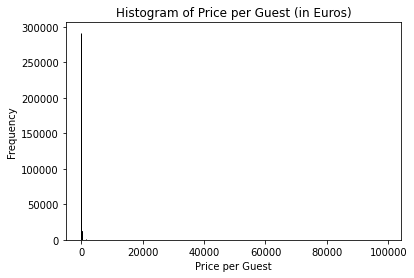

In [36]:
# now, we can plot the distribution of the prices per guest to detect any outliers

# Since the maximal value is so high, we will account for it in the histogram for now. For clarity and run time, we will use bins of width 100
plt.hist(all_listing_df_7['price_per_guest'], bins=range(0, 99150, 100), edgecolor='black')  # bins of 100 values (easier to see)
plt.xlabel('Price per Guest')
plt.ylabel('Frequency')
plt.title('Histogram of Price per Guest (in Euros)')
plt.show()

In [37]:
# This is clearly inefficient since pretty much all of the data is much lower. We will thus plot a histogram with only data within the 
# bottom 99% percentile

percentile_threshold = 0.99

# Calculate the threshold value
threshold_value = all_listing_df_7['price_per_guest'].quantile(percentile_threshold)

# Filter the DataFrame to include only values within the bottom 95% percentile
all_listing_df_8 = all_listing_df_7[all_listing_df_7['price_per_guest'] <= threshold_value]

all_listing_df_8["price_per_guest"].max()


250.0

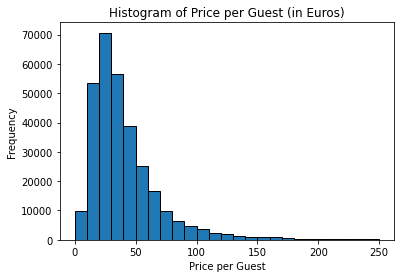

In [38]:

# plot the new histogram:
plt.hist(all_listing_df_8['price_per_guest'], bins=range(0, 260, 10), edgecolor='black')  # bins of 10 values (arbitrary value, just for us to see the distirbution clearly)
plt.xlabel('Price per Guest')
plt.ylabel('Frequency')
plt.title('Histogram of Price per Guest (in Euros)')
plt.show()


In [39]:
# This still seems like too big of a distribution. Considering that we are assuming that our investor has a fairly average budget, it is 
# unlikley that they will be able to afford to buy a property that is expensive enough to be worth more than around 100 euros per night per 
# person. As such, we will narrow down our values such that we only use values in the bottom 95% percentile.

percentile_threshold = 0.95

# Calculate the threshold value
threshold_value = all_listing_df_7['price_per_guest'].quantile(percentile_threshold)

# Filter the DataFrame to include only values within the bottom 95% percentile
all_listing_df_8 = all_listing_df_7[all_listing_df_7['price_per_guest'] <= threshold_value]

all_listing_df_8["price_per_guest"].max()


103.0

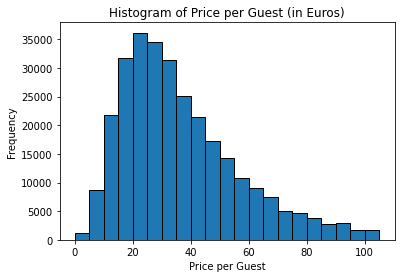

In [40]:
# plot the new histogram:

# note that here we will use bins of width 5, simply because it makes the data cleaner and easier to read. Additionally, it is unrealistic
# that when buying a property the investor knows exactly how much he will be charging per room; it is more likley that they will have a 
# rough idea of the price range. Hence, using bins > 1 makes sense. 

plt.hist(all_listing_df_8['price_per_guest'], bins=range(0, 110, 5), edgecolor='black')  # bins of 5 values 
plt.xlabel('Price per Guest')
plt.ylabel('Frequency')
plt.title('Histogram of Price per Guest (in Euros)')
plt.show()



As such, the final data frame with all suitable property listings is all_listing_df_8

## Consistency Analysis

### Creating dataset for average avaliability of listings per month per city

In [41]:

## add code that checks for the id 

def load_rental_data(city_name):
    """
    Load rental data for a specific city from a subdirectory.
    
    Parameters:
    - city_name (str): The name of the city.

    Returns:
    - pd.DataFrame: The loaded DataFrame.
    """
    # Construct the directory path based on the city name
    directory_path = f"home_rentals/{city_name}"
    
    # Assuming the file is named 'calendar.csv.gz'
    file_path = f"{directory_path}/calendar.csv.gz"
    
    try:
        # Load the DataFrame from the specified file
        df = pd.read_csv(file_path, compression='gzip')
        
        # You can perform additional processing on the DataFrame if needed
        
        # Return the loaded DataFrame
        return df
    except FileNotFoundError:
        # Handle the case where the file is not found
        print(f"Data not found for {city_name}. Check the directory path and file name.")
        return None
    

def filter_ids(df1, df2):
    """
    Filter out ID values in df1 that are not available in df2.

    Parameters:
    - df1 (pd.DataFrame): The first DataFrame.
    - df2 (pd.DataFrame): The second DataFrame.
    - id_column (str): The column containing the ID values.

    Returns:
    - pd.DataFrame: The filtered DataFrame.
    """
    id_column = "id"
    filtered_df = df1[df1["listing_id"].isin(df2["id"])]
    return filtered_df



def averageavaliability(city, latest_df):

    cityname = city
    citydata = load_rental_data(cityname) 

    #filter our ID's that are NOT present in our cleaned all_listings 

    filtered_citydata = filter_ids(citydata, latest_df)
    
    filtered_citydata["date"] = pd.to_datetime(filtered_citydata["date"])
    filtered_citydata["month"] = filtered_citydata["date"].dt.month
    filtered_citydata["year"] = filtered_citydata["date"].dt.year
    filtered_citydata['month_year'] = filtered_citydata['month'].astype(str) + '-' + filtered_citydata['year'].astype(str)

    # make a new data frame
    ave_month = (filtered_citydata[filtered_citydata['available'] == 't'].groupby(['listing_id', 'month_year']).size().unstack(fill_value=0).stack().reset_index(name='days_available'))
    
    # Calculate the average days_available for each month_year (making sure that it rounds to full numbers)
    ave_month = (ave_month.groupby('month_year')['days_available'].mean().round(0).reset_index(name='average_days_available'))
    # convert the month_year column to datetime format 
    ave_month['month_year'] = pd.to_datetime(ave_month['month_year'], format='%m-%Y').dt.to_period('M')

    # sort the rows by ascending dates
    ave_month = ave_month.sort_values('month_year')

    # reset the row index
    ave_month.reset_index(drop=True, inplace=True)

    ave_month['location'] = city

    return ave_month




In [42]:
# Will take 10 mins to run but it WORKSSSSSS SLAY

all_locations = all_listing_df_8["location"].unique()

average_by_month = pd.DataFrame()

for location in all_locations:
    ave_month = averageavaliability(location, all_listing_df_8)
    average_by_month = pd.concat([average_by_month, ave_month], axis=0)
    print(location)


    

C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3489930091.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["date"] = pd.to_datetime(filtered_citydata["date"])
C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3489930091.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["month"] = filtered_citydata["date"].dt.month
C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3489930091.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

Amsterdam


C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3489930091.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["date"] = pd.to_datetime(filtered_citydata["date"])
C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3489930091.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["month"] = filtered_citydata["date"].dt.month
C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3489930091.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

Barcelona


C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3489930091.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["date"] = pd.to_datetime(filtered_citydata["date"])
C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3489930091.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["month"] = filtered_citydata["date"].dt.month
C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3489930091.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

Euskadi


C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3489930091.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["date"] = pd.to_datetime(filtered_citydata["date"])
C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3489930091.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["month"] = filtered_citydata["date"].dt.month
C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3489930091.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

Geneva


C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3489930091.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["date"] = pd.to_datetime(filtered_citydata["date"])
C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3489930091.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["month"] = filtered_citydata["date"].dt.month
C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3489930091.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

Ireland


C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3489930091.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["date"] = pd.to_datetime(filtered_citydata["date"])
C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3489930091.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["month"] = filtered_citydata["date"].dt.month
C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3489930091.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

Lisbon


C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3489930091.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["date"] = pd.to_datetime(filtered_citydata["date"])
C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3489930091.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["month"] = filtered_citydata["date"].dt.month
C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3489930091.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

Los Angeles
Madrid


C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3489930091.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["date"] = pd.to_datetime(filtered_citydata["date"])
C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3489930091.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["month"] = filtered_citydata["date"].dt.month
C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3489930091.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

Malaga


C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3489930091.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["date"] = pd.to_datetime(filtered_citydata["date"])
C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3489930091.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["month"] = filtered_citydata["date"].dt.month
C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3489930091.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

Mallorca


C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3489930091.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["date"] = pd.to_datetime(filtered_citydata["date"])
C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3489930091.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["month"] = filtered_citydata["date"].dt.month
C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3489930091.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

Malta


C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3489930091.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["date"] = pd.to_datetime(filtered_citydata["date"])
C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3489930091.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["month"] = filtered_citydata["date"].dt.month
C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3489930091.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

Menorca


C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3489930091.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["date"] = pd.to_datetime(filtered_citydata["date"])
C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3489930091.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["month"] = filtered_citydata["date"].dt.month
C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3489930091.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

Mexico City


C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3489930091.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["date"] = pd.to_datetime(filtered_citydata["date"])
C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3489930091.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["month"] = filtered_citydata["date"].dt.month
C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3489930091.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

Milan


C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3489930091.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["date"] = pd.to_datetime(filtered_citydata["date"])
C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3489930091.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["month"] = filtered_citydata["date"].dt.month
C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3489930091.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

Naples


C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3489930091.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["date"] = pd.to_datetime(filtered_citydata["date"])
C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3489930091.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["month"] = filtered_citydata["date"].dt.month
C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3489930091.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

Rome


C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3489930091.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["date"] = pd.to_datetime(filtered_citydata["date"])
C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3489930091.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["month"] = filtered_citydata["date"].dt.month
C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3489930091.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

Rotterdam


C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3489930091.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["date"] = pd.to_datetime(filtered_citydata["date"])
C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3489930091.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["month"] = filtered_citydata["date"].dt.month
C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3489930091.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

San Diego


C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3489930091.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["date"] = pd.to_datetime(filtered_citydata["date"])
C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3489930091.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["month"] = filtered_citydata["date"].dt.month
C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3489930091.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

San Francisco


C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3489930091.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["date"] = pd.to_datetime(filtered_citydata["date"])
C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3489930091.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["month"] = filtered_citydata["date"].dt.month
C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3489930091.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

Tokyo


C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3489930091.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["date"] = pd.to_datetime(filtered_citydata["date"])
C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3489930091.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["month"] = filtered_citydata["date"].dt.month
C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3489930091.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

Toronto


C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3489930091.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["date"] = pd.to_datetime(filtered_citydata["date"])
C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3489930091.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["month"] = filtered_citydata["date"].dt.month
C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3489930091.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

Valencia


C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3489930091.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["date"] = pd.to_datetime(filtered_citydata["date"])
C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3489930091.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["month"] = filtered_citydata["date"].dt.month
C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3489930091.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

Vancouver


C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3489930091.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["date"] = pd.to_datetime(filtered_citydata["date"])
C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3489930091.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["month"] = filtered_citydata["date"].dt.month
C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3489930091.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

Vienna


C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3489930091.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["date"] = pd.to_datetime(filtered_citydata["date"])
C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3489930091.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["month"] = filtered_citydata["date"].dt.month
C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3489930091.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

Washington


C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3489930091.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["date"] = pd.to_datetime(filtered_citydata["date"])
C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3489930091.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["month"] = filtered_citydata["date"].dt.month
C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3489930091.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

Winnipeg


C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3489930091.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["date"] = pd.to_datetime(filtered_citydata["date"])
C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3489930091.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["month"] = filtered_citydata["date"].dt.month
C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3489930091.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

Zurich


C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3489930091.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata['month_year'] = filtered_citydata['month'].astype(str) + '-' + filtered_citydata['year'].astype(str)


In [43]:
# note that all of the properties in Madrid have no listing ID in the listings data file. Thus, we cannot merge the calendar and the listings
# data for the city because we do not have the corresponding IDs. As such, the function removed all of the Madrid properties. 

average_by_month["location"].unique()

array(['Amsterdam', 'Barcelona', 'Euskadi', 'Geneva', 'Ireland', 'Lisbon',
       'Los Angeles', 'Malaga', 'Mallorca', 'Malta', 'Menorca',
       'Mexico City', 'Milan', 'Naples', 'Rome', 'Rotterdam', 'San Diego',
       'San Francisco', 'Tokyo', 'Toronto', 'Valencia', 'Vancouver',
       'Vienna', 'Washington', 'Winnipeg', 'Zurich'], dtype=object)

### Correcting for additional months

In [44]:
# check for the unique "month_year" vaues in the average_by_month dataframe. This allows us to see what months are covered by the data
average_by_month["month_year"].unique()


<PeriodArray>
['2022-09', '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
 '2023-04', '2023-05', '2023-06', '2023-07', '2023-08', '2023-09', '2023-10']
Length: 14, dtype: period[M]

In [45]:
# All of the locations should have data from 2022-09 until 2023-09. From above, we see that some locations also have 2023-10
# loop through the dataframe and remove observations in 2023-10 for any locations that may have them

# Create a boolean mask based on the specified conditions
mask = average_by_month['month_year'] == "2023-10"

# Use the boolean mask to filter the DataFrame and keep only the rows that don't match the conditions
average_by_month = average_by_month[~mask]

# check that we got the result we wanted
average_by_month["month_year"].value_counts()



month_year
2022-09    26
2022-10    26
2022-11    26
2022-12    26
2023-01    26
2023-02    26
2023-03    26
2023-04    26
2023-05    26
2023-06    26
2023-07    26
2023-08    26
2023-09    26
Freq: M, Name: count, dtype: int64

### Seasonality Analysis

Next, we will look at the seasonality of each month for each location, comparing it between the locations and calculating a seasonality index. We do this so as to have an idea of how consistent the bookings are per month for each location.

In [46]:
# Calculate the seasonality index for each month of each location

# find the average availability per month between all locations
seasonality_df = average_by_month
seasonality_df['Average'] = seasonality_df.groupby('month_year')['average_days_available'].transform('mean')

# calculate the seasonality index for each location's month and append it to the dataframe 
seasonality_df['Seasonality_Index_%'] = round((seasonality_df['average_days_available'] / seasonality_df['Average']) * 100,1)

# remove the Average column since it is no longer needed
#seasonality_df = seasonality_df.drop("Average", axis=1)

# show the data frame 
seasonality_df




,month_year,average_days_available,location,Average,Seasonality_Index_%
0,2022-09,3.0,Amsterdam,3.730769,80.4
1,2022-10,6.0,Amsterdam,14.269231,42.0
2,2022-11,10.0,Amsterdam,18.500000,54.1
3,2022-12,10.0,Amsterdam,19.038462,52.5
4,2023-01,13.0,Amsterdam,19.307692,67.3
...,...,...,...,...,...
8,2023-05,15.0,Zurich,16.576923,90.5
9,2023-06,14.0,Zurich,15.500000,90.3
10,2023-07,14.0,Zurich,15.500000,90.3
11,2023-08,15.0,Zurich,15.730769,95.4


The seasonality index indicates how the availability per month of each location varies with respect to a seasonal pattern. A seasonality index value above 100% indicates a period of higher demand or availability compared to the average. A seasonality index value below 100%, instead, indicates a period of lower demand or availability compared to the average. Finally, a seasonality index of 100% suggests that the availability is in line with the average, without any significant seasonal deviation.

In order to visualise the above results better, we will generate a bar graph for each location showing the average days available and the seasonality of each month in the location. In this way, we can get a better idea of the actual days of availability per month in each location, and how this value compares with other locations (we see this via the seasonality index).

C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3464662411.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)
C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3464662411.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


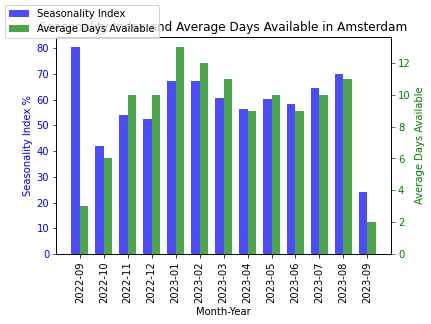

C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3464662411.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)
C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3464662411.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


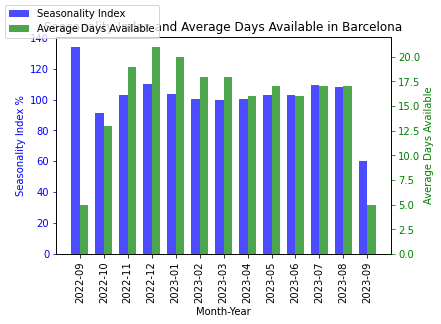

C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3464662411.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)
C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3464662411.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


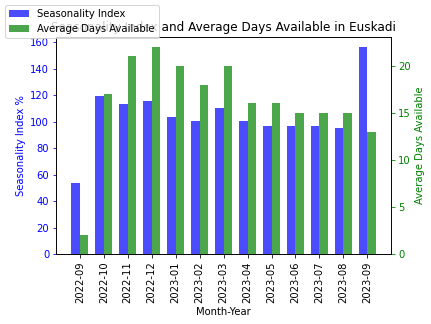

C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3464662411.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)
C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3464662411.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


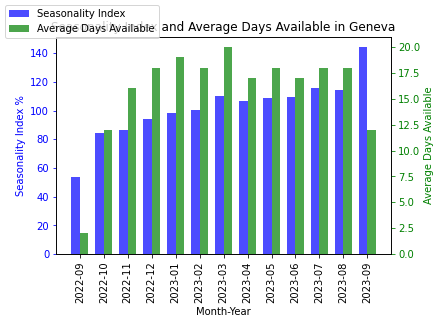

C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3464662411.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)
C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3464662411.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


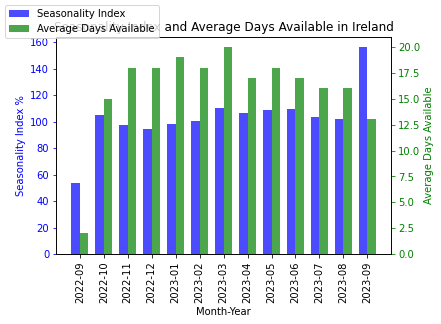

C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3464662411.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)
C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3464662411.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


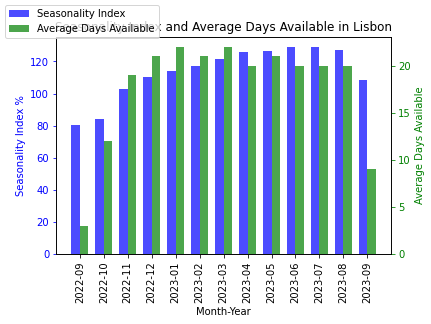

C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3464662411.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)
C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3464662411.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


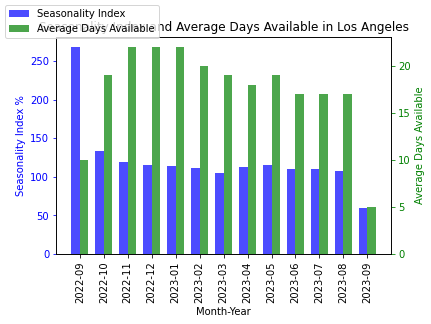

C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3464662411.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)
C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3464662411.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


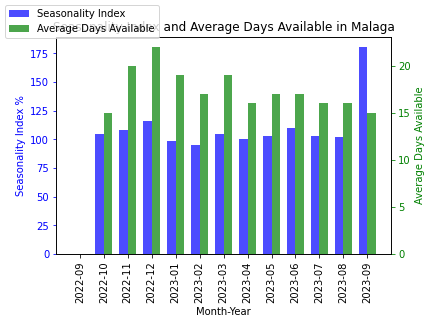

C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3464662411.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)
C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3464662411.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


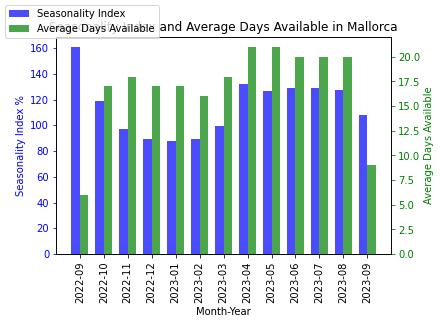

C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3464662411.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)
C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3464662411.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


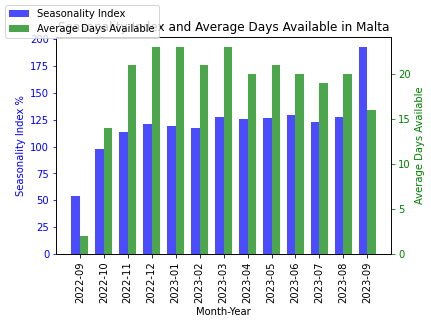

C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3464662411.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)
C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3464662411.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


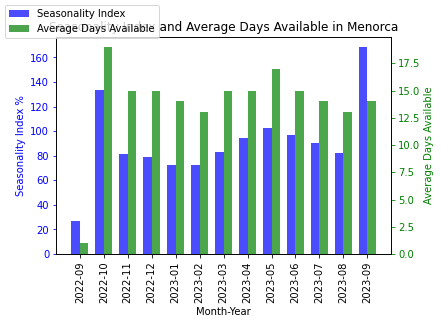

C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3464662411.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)
C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3464662411.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


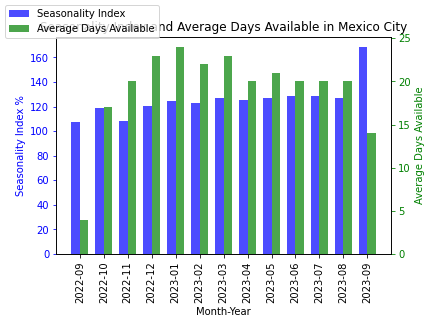

C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3464662411.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)
C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3464662411.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


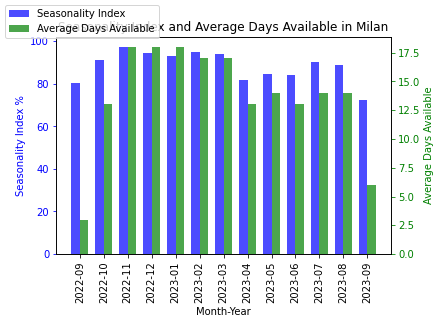

C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3464662411.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)
C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3464662411.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


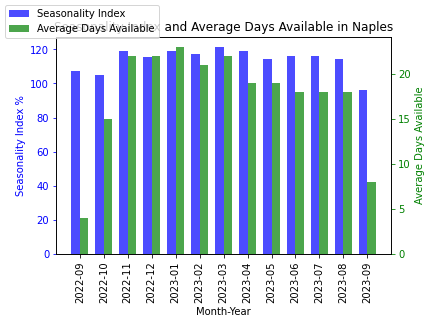

C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3464662411.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)
C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3464662411.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


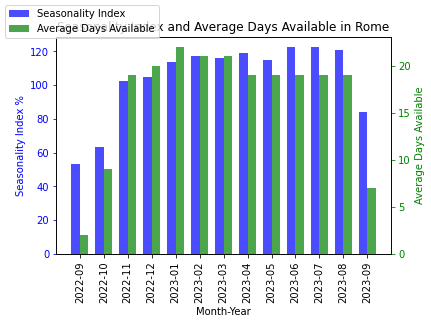

C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3464662411.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)
C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3464662411.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


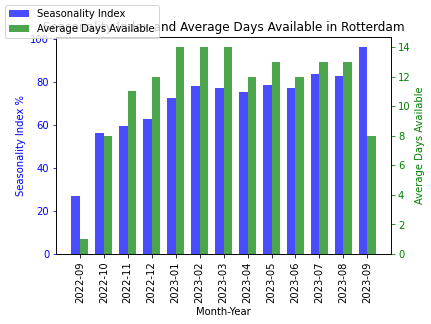

C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3464662411.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)
C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3464662411.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


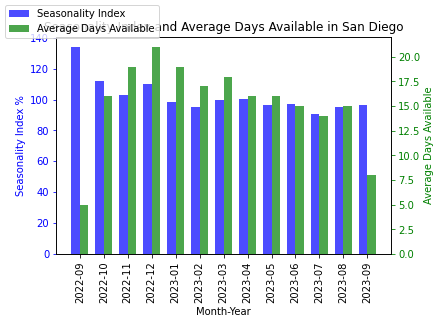

C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3464662411.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)
C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3464662411.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


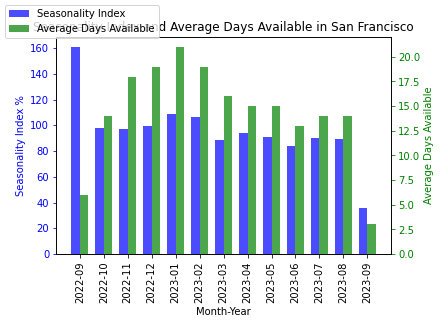

C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3464662411.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)
C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3464662411.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


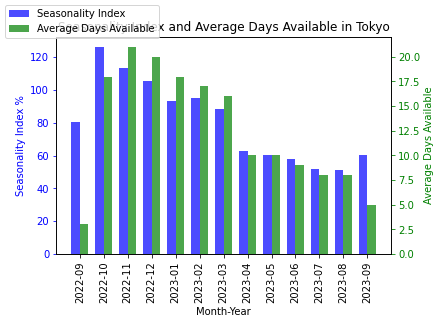

C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3464662411.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)
C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3464662411.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


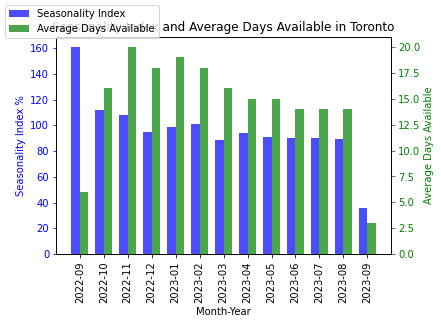

C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3464662411.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)
C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3464662411.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


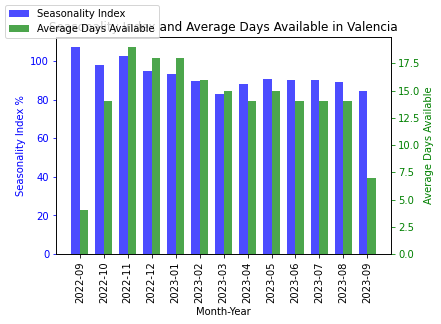

C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3464662411.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)
C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3464662411.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


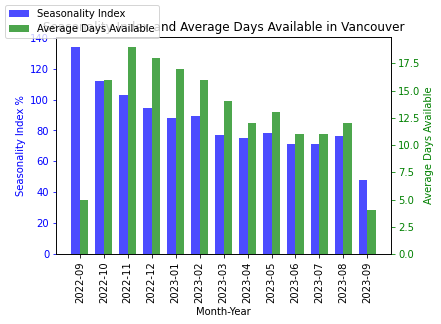

C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3464662411.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)
C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3464662411.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


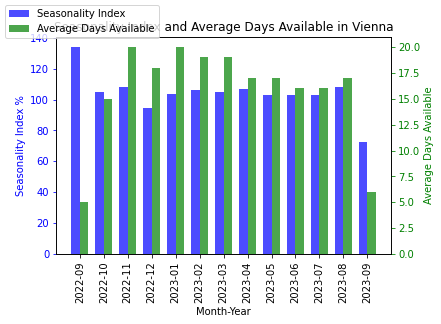

C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3464662411.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)
C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3464662411.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


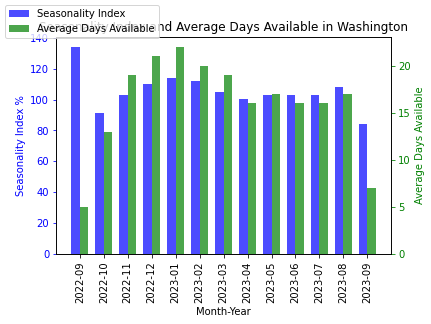

C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3464662411.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)
C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3464662411.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


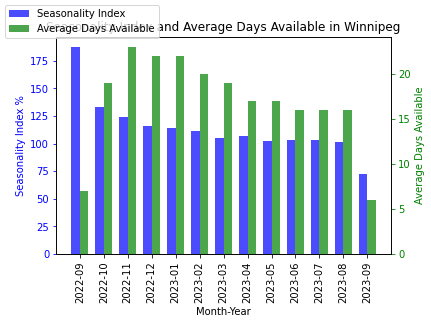

C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3464662411.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)
C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\3464662411.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


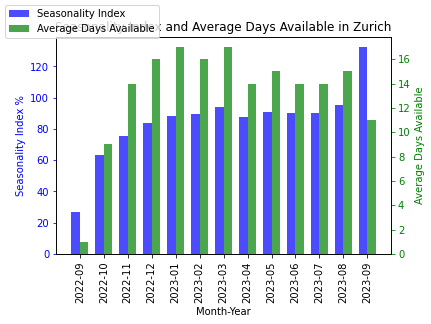

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Plot the monthly availability and seasonality index for each location

all_the_locations = average_by_month["location"].unique()

# Set the width of the bars
bar_width = 0.35

# Make the bar charts
for location in all_the_locations:

    season_given_location = seasonality_df[seasonality_df["location"] == location]
    location_name = average_by_month[average_by_month['location'] == location]

    av_si = season_given_location['Seasonality_Index_%']
    av_availability = location_name['average_days_available']

    season_given_location['month_year'] = season_given_location['month_year'].astype(str)
    location_name['month_year'] = location_name['month_year'].astype(str)

    # Create a figure and primary y-axis
    fig, ax1 = plt.subplots()

    # Plot Seasonality Index on the primary y-axis
    ax1.bar(np.arange(len(season_given_location['month_year'])), av_si, width=bar_width, color='blue', alpha=0.7, label='Seasonality Index')
    ax1.set_xlabel('Month-Year')
    ax1.set_ylabel('Seasonality Index %', color='blue')
    ax1.tick_params('y', colors='blue')
    ax1.set_title(f'Seasonality Index and Average Days Available in {location}')

    # Create a twin Axes sharing the x-axis
    ax2 = ax1.twinx()

    # Plot Average Days Available on the secondary y-axis
    ax2.bar(np.arange(len(location_name['month_year'])) + bar_width, av_availability, width=bar_width, color='green', alpha=0.7, label='Average Days Available')
    ax2.set_ylabel('Average Days Available', color='green')
    ax2.tick_params('y', colors='green')

    # Set x-axis ticks and labels
    ax1.set_xticks(np.arange(len(season_given_location['month_year'])) + bar_width / 2)
    ax1.set_xticklabels(season_given_location['month_year'], rotation=90)

    # Display the legend
    fig.legend(loc='upper left')

    # Show the plot
    plt.show()


The graphs above allow us to gain a better understanding of the distribution of our data, however there is too much data (and thus it is too specific) for it to be useful when building models. As such, we will calculate a single seasonality index for each location. 

In [48]:
# Calculate the seasonality index for each location

# find the average availability for each locations
seasonality_per_location_df = pd.DataFrame()

seasonality_per_location_df["location"] = average_by_month["location"].unique()

# calculate one average availability per location
for location in all_locations:
    average_avail_per_loc_df = average_by_month.groupby('location')['average_days_available'].mean().reset_index()

# add the average availability of each location to the data frame:
seasonality_per_location_df["average_availability"] = average_avail_per_loc_df["average_days_available"]

# calculate the average availabiity between all locations
average_availbility = average_avail_per_loc_df["average_days_available"].mean()

# calculate the seasonality index for each location and append it to the dataframe 
seasonality_per_location_df['Seasonality_Index_%'] = round((seasonality_per_location_df["average_availability"] / average_availbility) * 100,1)

# show the data frame 
seasonality_per_location_df


,location,average_availability,Seasonality_Index_%
0,Amsterdam,8.923077,58.5
1,Barcelona,15.538462,101.8
2,Euskadi,16.153846,105.9
3,Geneva,15.769231,103.3
4,Ireland,15.923077,104.3
5,Lisbon,17.692308,115.9
6,Los Angeles,17.461538,114.4
7,Malaga,16.076923,105.4
8,Mallorca,16.923077,110.9
9,Malta,18.692308,122.5


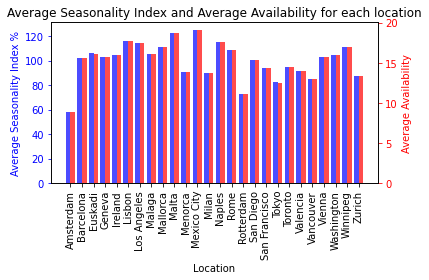

In [49]:
# let's plot the seasonality index and average availability of all locations on one graph:

import matplotlib.pyplot as plt
import numpy as np

# make the bar chart
fig, ax1 = plt.subplots()
bar_width = 0.4
indices = np.arange(len(seasonality_per_location_df['location']))

# plot first axis
ax1.bar(indices - bar_width / 2, seasonality_per_location_df['Seasonality_Index_%'], color='b', alpha=0.7, label='Average Seasonality Index %', width=bar_width)
ax1.set_xlabel('Location')
ax1.set_ylabel('Average Seasonality Index %', color='b')
ax1.set_xticks(indices)
ax1.set_xticklabels(seasonality_per_location_df['location'], rotation=90)  # Rotate x-axis labels vertically
ax1.tick_params('y', colors='b')

# Twin axis for Average Availability on the right axis
ax2 = ax1.twinx()
# Adjust the x-coordinates for the second set of bars
ax2.bar(indices + bar_width / 2, seasonality_per_location_df['average_availability'], color='r', alpha=0.7, label='Average Availability', width=bar_width)
ax2.set_ylabel('Average Availability', color='r')
ax2.tick_params('y', colors='r')

# Title and legend
plt.title('Average Seasonality Index and Average Availability for each location')
fig.tight_layout()
plt.show()

As expected, the average seasonality index and the average availability distributions exactly match each other. This is because, to calculate the seasonality, we are simply taking the average availability of the location and multiplying it by a constant (100 / average availability of data set). 

Although the seasonality index gives us a good insight of the general distribution of availabilities of locations, we have determined that it is superfluous in the context of building our models. This is because the objective of the model is to tell an investor where the best location to buy a property destined to be rented out on Airbnb would be, and thus the investor is not interested in the monthly seasonality of the location, but rather the yearly one (since the property is to be rented out for the whole year). However, since the yearly seasonality index is matched by the average availability of the property, it is easier to simply look at the average availability of the locations and discard the seasonality index. 

# Model generation

## Profitability

First of all, we have to define the metric that we want our models to calculate. In this case, we want the models to tell us what the most profitable location to buy a property to then rent on Airbnb would be. We can calculate profitability by calculating how many nights on average properties in each location are booked per month multiplied by the average price per guest paid per night. 

In [50]:
# first, have to find the average price_per_guest per location

# create the new data frame 
average_ppg_per_location_wM = all_listing_df_8.groupby('location')['price_per_guest'].mean().reset_index(name='average_price_per_guest')

# round the values to 2 decimal places
average_ppg_per_location_wM['average_price_per_guest'] = round(average_ppg_per_location_wM['average_price_per_guest'],2)

# also, have to remember to remove the data for Madrid since the ave_month data frame doesn't have any data for it (as explained earlier)
average_ppg_per_location = average_ppg_per_location_wM[average_ppg_per_location_wM['location'] != "Madrid"]

# reset the index
average_ppg_per_location = average_ppg_per_location.reset_index(drop=True)

# show the new data frame
average_ppg_per_location


,location,average_price_per_guest
0,Amsterdam,60.68
1,Barcelona,35.74
2,Euskadi,35.02
3,Geneva,42.50
4,Ireland,36.44
5,Lisbon,32.82
6,Los Angeles,45.41
7,Malaga,27.96
8,Mallorca,41.39
9,Malta,27.28


In [51]:
# Next, calculate the average monthly availability of each location (note that the latter comes from the average_by_month dataframe)

average_availbility_per_location = pd.DataFrame()

average_availbility_per_location["location"] = average_by_month["location"].unique()

# calculate one average availability per location
for location in all_locations:
    average_availbility_per_location = average_by_month.groupby('location')['average_days_available'].mean().reset_index()

# show the data frame
average_availbility_per_location

,location,average_days_available
0,Amsterdam,8.923077
1,Barcelona,15.538462
2,Euskadi,16.153846
3,Geneva,15.769231
4,Ireland,15.923077
5,Lisbon,17.692308
6,Los Angeles,17.461538
7,Malaga,16.076923
8,Mallorca,16.923077
9,Malta,18.692308


In [52]:
# we then have to use the average availability per location to calculate the average days booked 
# since we have an average value for each month, we will have to use the average days between all months to find the days booked (note that 
# 2023 was not a leap year, thus take 29 days for february). 

average_days_in_month = (31*7 + 30*4 + 28)/12

average_bookings_per_location = pd.DataFrame()

average_bookings_per_location["location"] = average_availbility_per_location['location']
average_bookings_per_location["average_days_booked"] = average_days_in_month - average_availbility_per_location["average_days_available"]

# round to a full number of days
average_bookings_per_location["average_days_booked"] = round(average_bookings_per_location["average_days_booked"],0)

# show dataframe
average_bookings_per_location



,location,average_days_booked
0,Amsterdam,21.0
1,Barcelona,15.0
2,Euskadi,14.0
3,Geneva,15.0
4,Ireland,14.0
5,Lisbon,13.0
6,Los Angeles,13.0
7,Malaga,14.0
8,Mallorca,13.0
9,Malta,12.0


In [53]:
# now, we can calculate the profitability by multiplying the average price paid per guest in each location with the average days booked in each 
# location (this value is for a month)

profitability_per_location = pd.DataFrame()

# add a location and profitability column
profitability_per_location["location"] = average_bookings_per_location["location"]
profitability_per_location["profitability"] = 0


# calculate the profitability per column and write it in
for location in profitability_per_location["location"]:
    profitability_per_location.loc[profitability_per_location["location"]== location, "profitability"] = average_bookings_per_location.loc[average_bookings_per_location["location"] == location, "average_days_booked"] * average_ppg_per_location.loc[average_ppg_per_location["location"] == location, 'average_price_per_guest']

# show the data frame
profitability_per_location

C:\Users\elisa\AppData\Local\Temp\ipykernel_27472\336204506.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1274.28]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  profitability_per_location.loc[profitability_per_location["location"]== location, "profitability"] = average_bookings_per_location.loc[average_bookings_per_location["location"] == location, "average_days_booked"] * average_ppg_per_location.loc[average_ppg_per_location["location"] == location, 'average_price_per_guest']


,location,profitability
0,Amsterdam,1274.28
1,Barcelona,536.10
2,Euskadi,490.28
3,Geneva,637.50
4,Ireland,510.16
5,Lisbon,426.66
6,Los Angeles,590.33
7,Malaga,391.44
8,Mallorca,538.07
9,Malta,327.36


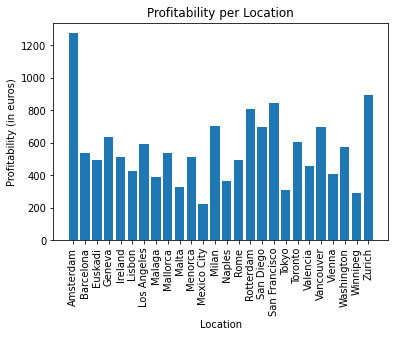

In [107]:
# finally, let's plot the profitability of each location so that we can compare them more easily 

import matplotlib.pyplot as plt

# Plotting the bar plot
plt.bar(profitability_per_location['location'], profitability_per_location['profitability'])

# Adding labels and title
plt.xlabel('Location')
plt.ylabel('Profitability (in euros)')
plt.title('Profitability per Location')

# Rotating x-axis labels vertically
plt.xticks(rotation='vertical')

# Show the plot
plt.show()

## Linear regression

In [54]:
from sklearn.metrics import classification_report
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [55]:
X = all_listing_df_8.drop('availability_365', axis=1)
y = all_listing_df_8['availability_365']


x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=12345)

In [56]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [57]:
all_listing_df_8.columns

Index(['id', 'property_type', 'room_type', 'accommodates', 'amenities',
       'price', 'minimum_nights', 'maximum_nights', 'availability_30',
       'availability_365', 'location', 'Euro_price', 'price_per_guest'],
      dtype='object')

In [58]:
columns_to_drop = ['id', 'price', 'price_per_guest']

# Assuming df is your DataFrame

all_listing_df_9 = all_listing_df_8.drop(columns_to_drop, axis=1)
# Drop rows with NaN values
df_cleaned = all_listing_df_9.dropna()

In [59]:


# One-Hot Encode the Categorical Variables
df_encoded = pd.get_dummies(
    df_cleaned, columns=['property_type', 'room_type', 'location'])

# Split Data into Features (X) and Target (y)
# Assuming 'price' is your target variable
X = df_encoded.drop(['availability_365'], axis=1)
y = df_encoded['availability_365']

# Split the Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1234)

In [60]:
'''
#with label encoded (each column)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Assuming df_cleaned is your cleaned DataFrame

# Initialize LabelEncoders
le_property_type = LabelEncoder()
le_room_type = LabelEncoder()
le_location = LabelEncoder()

# Apply LabelEncoder to each categorical column
df_cleaned['property_type_encoded'] = le_property_type.fit_transform(
    df_cleaned['property_type'])
df_cleaned['room_type_encoded'] = le_room_type.fit_transform(
    df_cleaned['room_type'])
df_cleaned['location_encoded'] = le_location.fit_transform(
    df_cleaned['location'])

# Drop original categorical columns
df_cleaned.drop(['property_type', 'room_type', 'location'],
                axis=1, inplace=True)

# Split Data into Features (X) and Target (y)
# Assuming 'availability_365' is your target variable
X = df_cleaned.drop(['availability_365'], axis=1)
y = df_cleaned['availability_365']

# Split the Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1234)

df_cleaned

'''

"\n#with label encoded (each column)\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.preprocessing import LabelEncoder\n\n# Assuming df_cleaned is your cleaned DataFrame\n\n# Initialize LabelEncoders\nle_property_type = LabelEncoder()\nle_room_type = LabelEncoder()\nle_location = LabelEncoder()\n\n# Apply LabelEncoder to each categorical column\ndf_cleaned['property_type_encoded'] = le_property_type.fit_transform(\n    df_cleaned['property_type'])\ndf_cleaned['room_type_encoded'] = le_room_type.fit_transform(\n    df_cleaned['room_type'])\ndf_cleaned['location_encoded'] = le_location.fit_transform(\n    df_cleaned['location'])\n\n# Drop original categorical columns\ndf_cleaned.drop(['property_type', 'room_type', 'location'],\n                axis=1, inplace=True)\n\n# Split Data into Features (X) and Target (y)\n# Assuming 'availability_365' is your target variable\nX = df_cleaned.drop(['availability_365'], axis=1)\ny = df_cleaned['availability_365']\n\n# Split the 

In [60]:


# Fit the Model on the Training Data
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on Test Data
y_pred = model.predict(X_test)

# Calculate Performance Metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

C:\Users\elisa\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\elisa\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\elisa\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


ValueError: could not convert string to float: '["Hangers", "Dishes and silverware", "Beachfront", "Iron", "Outdoor dining area", "Outdoor shower", "Toaster", "Body soap", "43\\" HDTV with Netflix", "First aid kit", "Long term stays allowed", "Room-darkening shades", "Hot water", "Carbon monoxide alarm", "Cooking basics", "Cleaning before checkout", "Central air conditioning", "Free washer \\u2013 In building", "Stainless steel oven", "Extra pillows and blankets", "Hot water kettle", "Essentials", "Kitchen", "Barbecue utensils", "Refrigerator", "Single level home", "Waterfront", "Folding or convertible high chair - available upon request", "Mini fridge", "Luggage dropoff allowed", "Dining table", "Clothing storage: wardrobe", "Free street parking", "Fire extinguisher", "Wifi", "Free dryer \\u2013 In building", "Microwave", "Shampoo", "Hair dryer", "Coffee maker", "Outdoor furniture", "Smoke alarm", "Elevator", "Dedicated workspace", "Wine glasses", "Pack \\u2019n play/Travel crib - available upon request", "Private patio or balcony", "BBQ grill", "Shower gel", "Heating - split type ductless system", "Stainless steel stove", "Smart lock", "Cleaning products", "Bed linens"]'

In [ ]:
df_encoded

,accommodates,minimum_nights,maximum_nights,availability_30,availability_365,Euro_price,property_type_Entire bungalow,property_type_Entire condo,property_type_Entire cottage,property_type_Entire guest suite,...,location_San Diego,location_San Francisco,location_Tokyo,location_Toronto,location_Valencia,location_Vancouver,location_Vienna,location_Washington,location_Winnipeg,location_Zurich
1,3.0,1,9999.0,0.0,0.0,193.20,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1.0,5,31.0,0.0,221.0,63.00,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,3.0,2,30.0,0.0,208.0,72.45,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7,2.0,5,30.0,6.0,6.0,163.80,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8,1.0,1,1125.0,3.0,310.0,75.60,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342230,4.0,5,90.0,4.0,5.0,72.00,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
342231,6.0,21,60.0,0.0,0.0,265.00,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
342232,2.0,5,1125.0,3.0,3.0,31.00,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
342233,4.0,3,1125.0,0.0,2.0,90.00,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
from sklearn.metrics import mean_absolute_error

# Calculate Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

# RMSE was already calculated in your code, but here it is again for reference
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error: {rmse}")

Mean Absolute Error: 101.75902572196158
Root Mean Squared Error: 114.71143382407503


In [ ]:
r2 = r2_score(y_test, y_pred)
r2_percentage = r2 * 100

print(f"R-squared (as a percentage): {r2_percentage:.2f}%")

R-squared (as a percentage): 26.62%


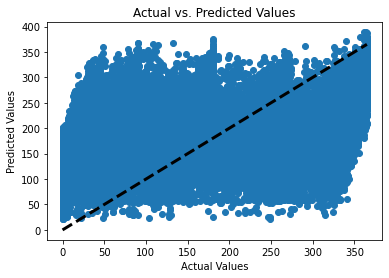

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         'k--', lw=3)  # Line for perfect predictions
plt.show()

## KNN

We will also try to build a model using KNN (k-Nearest Neighbors). As before, we are trying to predict the average profitability of each location so as to find what the most profitable location to buy a property in is. 

In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

# SUGGESTION TO IMPROVE MODEL PERFORMANCE : add back bedrooms and amenities







In [ ]:
"""

# econdings for property type, room type and location ALREADY DONE DONT NEED

# Use scikit-learn's OneHotEncoder
encoder = OneHotEncoder(sparse=False)

ptype_encoded = encoder.fit_transform(all_listing_df_8[['property_type']])

# Convert to DataFrame for better visualization
ptype_df = pd.DataFrame(ptype_encoded, columns=encoder.get_feature_names(['property_type']))


#for room type 
encoder = OneHotEncoder(sparse=False)

rtype_encoded = encoder.fit_transform(all_listing_df_8[['room_type']])

# Convert to DataFrame with correct number of columns

rtype_df = pd.DataFrame(rtype_encoded, columns=encoder.get_feature_names(['room_type']))


#for location


location_encoded = encoder.fit_transform(all_listing_df_8[['location']])


location_df = pd.DataFrame(location_encoded, columns=encoder.get_feature_names(['location']))

"""

"\n\n# econdings for property type, room type and location\n\n# Use scikit-learn's OneHotEncoder\nencoder = OneHotEncoder(sparse=False)\n\nptype_encoded = encoder.fit_transform(all_listing_df_8[['property_type']])\n\n# Convert to DataFrame for better visualization\nptype_df = pd.DataFrame(ptype_encoded, columns=encoder.get_feature_names(['property_type']))\n\n\n#for room type \nencoder = OneHotEncoder(sparse=False)\n\nrtype_encoded = encoder.fit_transform(all_listing_df_8[['room_type']])\n\n# Convert to DataFrame with correct number of columns\n\nrtype_df = pd.DataFrame(rtype_encoded, columns=encoder.get_feature_names(['room_type']))\n\n\n#for location\n\n\nlocation_encoded = encoder.fit_transform(all_listing_df_8[['location']])\n\n\nlocation_df = pd.DataFrame(location_encoded, columns=encoder.get_feature_names(['location']))\n\n"

In [ ]:
df_encoded

,accommodates,minimum_nights,maximum_nights,availability_30,availability_365,Euro_price,property_type_Entire bungalow,property_type_Entire condo,property_type_Entire cottage,property_type_Entire guest suite,...,location_San Diego,location_San Francisco,location_Tokyo,location_Toronto,location_Valencia,location_Vancouver,location_Vienna,location_Washington,location_Winnipeg,location_Zurich
1,3.0,1,9999.0,0.0,0.0,193.20,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1.0,5,31.0,0.0,221.0,63.00,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,3.0,2,30.0,0.0,208.0,72.45,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7,2.0,5,30.0,6.0,6.0,163.80,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8,1.0,1,1125.0,3.0,310.0,75.60,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342230,4.0,5,90.0,4.0,5.0,72.00,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
342231,6.0,21,60.0,0.0,0.0,265.00,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
342232,2.0,5,1125.0,3.0,3.0,31.00,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
342233,4.0,3,1125.0,0.0,2.0,90.00,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
X = df_encoded.drop(['availability_365'], axis=1)
y = df_encoded['availability_365']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
k = 9  # You can choose the value of k based on cross-validation or other techniques (crossval gave 9)
knn_model = KNeighborsRegressor(n_neighbors=k)
knn_model.fit(X_train_scaled, y_train)

KNeighborsRegressor(n_neighbors=9)

In [ ]:
y_pred = knn_model.predict(X_test_scaled)

In [ ]:
# evaluations


mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')



Mean Squared Error: 12877.532318163223
R-squared: 0.27769195236593813


In [ ]:
# tuning hyperparameters 

""" 
from sklearn.model_selection import GridSearchCV

param_grid = {'n_neighbors': [3, 5, 7, 9]}
grid_search = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train)

best_k = grid_search.best_params_['n_neighbors']
print(f'Best value for k: {best_k}')

"""

" \nfrom sklearn.model_selection import GridSearchCV\n\nparam_grid = {'n_neighbors': [3, 5, 7, 9]}\ngrid_search = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5)\ngrid_search.fit(X_train_scaled, y_train)\n\nbest_k = grid_search.best_params_['n_neighbors']\nprint(f'Best value for k: {best_k}')\n\n"

# Neural Net


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np